# Importamos las librerias que utilizaremos
# Objetivo
Crear una red neuronal tipo LSTM y time series Generator

In [1]:
# importamoes las librerias clásicas

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)

# Importo mi data a analizar

In [2]:
link ='https://docs.google.com/spreadsheets/d/e/2PACX-1vQhnB8YqczzjUWag4mgARd3cE9jMAvzE-pf9LRKKaUgiMB6KpAWgVWHMk1eff3KiD8Wpyej4BdzL7EI/pub?gid=637213270&single=true&output=csv'
df= pd.read_csv(link, sep=';')



In [3]:
#tengo que agregar

df.head()

,M2,INPC
0,28.7700,59.8083
1,29.3109,60.3388
2,29.8290,60.6734
3,30.1613,61.0186
4,30.4289,61.2467


In [4]:
df = pd.DataFrame(df, columns=['Period', 'INPC'])
df

,Period,INPC
0,NaN,59.8083
1,NaN,60.3388
2,NaN,60.6734
3,NaN,61.0186
4,NaN,61.2467
...,...,...
171,NaN,112.8880
172,NaN,112.5270
173,NaN,112.7220
174,NaN,113.0320


In [5]:
df['Period'] = pd.date_range("2000-01-01", periods=176, freq="M")
df.tail()

,Period,INPC
171,2014-04-30,112.888
172,2014-05-31,112.527
173,2014-06-30,112.722
174,2014-07-31,113.032
175,2014-08-31,113.438


In [6]:
df = pd.DataFrame(df)
df.set_index('Period', inplace = True)

In [7]:
df.dtypes

INPC    float64
dtype: object

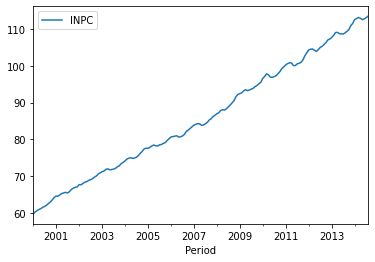

In [8]:
df.plot()

In [9]:
# Train Test Split

len(df) , len(df)-12


(176, 164)

In [10]:
train=df.iloc[:len(df)-12]
test=df.iloc[len(df)-12:]

In [11]:
len(train),len(test)

(164, 12)

Escalar data

In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaler = scaler.fit(train)

In [15]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [16]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
scaled_train[:6]

array([[0.        ],
       [0.01076814],
       [0.01755988],
       [0.02456679],
       [0.02919678],
       [0.03656093]])

In [18]:
# Definimos el generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size=1)

In [19]:
len(train)

164

In [20]:
len(generator) # n_input = 2

162

In [21]:
scaled_train[:5]

array([[0.        ],
       [0.01076814],
       [0.01755988],
       [0.02456679],
       [0.02919678]])

In [22]:
# ¿Cómo luce el primer batch?
generator[0]

(array([[[0.        ],
         [0.01076814]]]), array([[0.01755988]]))

In [23]:
X,y = generator[0]

In [24]:
print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')

Datos: 
[0.         0.01076814]
Predicción: 
 [[0.01755988]]


In [25]:
# Vamos a redefinir para que utilice 12 meses y luego prediga el próximo mes
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size=1)

In [26]:
# ¿Cómo luce el primer batch?
X,y = generator[0]

In [27]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.01076814 0.01755988 0.02456679 0.02919678 0.03656093
 0.04143857 0.04833586 0.05755729 0.06631389 0.07726065 0.09123995]
Predict this y: 
 [[0.09847622]]


# Creando el modelo LSTM

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [29]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [31]:
# fit model
model.fit_generator(generator,epochs=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


152/152 [==============================] - 4s 10ms/step - loss: 0.0203
Epoch 2/5
152/152 [==============================] - 2s 10ms/step - loss: 2.6723e-04
Epoch 3/5
152/152 [==============================] - 1s 10ms/step - loss: 5.2547e-04
Epoch 4/5
152/152 [==============================] - 1s 10ms/step - loss: 3.9366e-04
Epoch 5/5
152/152 [==============================] - 2s 11ms/step - loss: 2.8911e-04


In [32]:
model.history.history.keys()

dict_keys(['loss'])

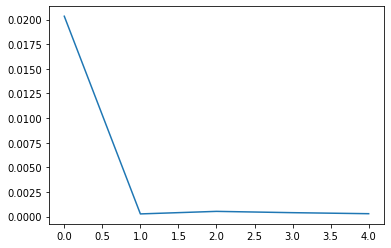

In [33]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# Evaluando datos de prueba

In [34]:
# 12 meses de historia ---> predecir el 13
# Necesitaremos los últimos 12 meses del conjunto de entrenamiento para predecir el 1er mes en el conjunto de prueba
first_eval_batch = scaled_train[-12:]

In [35]:
first_eval_batch

array([[0.93238704],
       [0.94324652],
       [0.95790175],
       [0.96289508],
       [0.97166386],
       [0.98242185],
       [0.99853854],
       [1.        ],
       [0.99263179],
       [0.99129212],
       [0.99056138],
       [0.9968335 ]])

In [36]:
X.shape

(1, 12, 1)

In [37]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [38]:
first_eval_batch.shape

(1, 12, 1)

In [39]:
model.predict(first_eval_batch)

array([[1.0239034]], dtype=float32)

In [40]:
scaled_test

array([[1.00515572],
       [1.01571073],
       [1.03649598],
       [1.04940557],
       [1.06964277],
       [1.07542773],
       [1.08169984],
       [1.07741695],
       [1.07008933],
       [1.07404746],
       [1.08033987],
       [1.0885809 ]])

# función recursiva
Ahora pongamos esta lógica en un bucle for para predecir el futuro para todo el rango de prueba.

In [41]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [42]:
test_predictions

[array([1.0239034], dtype=float32),
 array([1.0315247], dtype=float32),
 array([1.0391686], dtype=float32),
 array([1.0466346], dtype=float32),
 array([1.0543182], dtype=float32),
 array([1.0619847], dtype=float32),
 array([1.0695754], dtype=float32),
 array([1.0768913], dtype=float32),
 array([1.0846661], dtype=float32),
 array([1.0934055], dtype=float32),
 array([1.1027197], dtype=float32),
 array([1.1125618], dtype=float32)]

In [43]:
scaled_test

array([[1.00515572],
       [1.01571073],
       [1.03649598],
       [1.04940557],
       [1.06964277],
       [1.07542773],
       [1.08169984],
       [1.07741695],
       [1.07008933],
       [1.07404746],
       [1.08033987],
       [1.0885809 ]])

Transformación inversa y Comparación

In [44]:
# son los valores originales de las predicciones data test
true_predictions = scaler.inverse_transform(test_predictions)

In [45]:
true_predictions

array([[110.25161625],
       [110.62708435],
       [111.00366831],
       [111.37148399],
       [111.75002363],
       [112.12771758],
       [112.50168221],
       [112.86210387],
       [113.2451363 ],
       [113.67568661],
       [114.13455618],
       [114.61943695]])

In [46]:
test

,INPC
Period,
2013-09-30,109.328
2013-10-31,109.848
2013-11-30,110.872
2013-12-31,111.508
2014-01-31,112.505
2014-02-28,112.790
2014-03-31,113.099
2014-04-30,112.888
2014-05-31,112.527


In [47]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
test

,INPC,Predictions
Period,,
2013-09-30,109.328,110.251616
2013-10-31,109.848,110.627084
2013-11-30,110.872,111.003668
2013-12-31,111.508,111.371484
2014-01-31,112.505,111.750024
2014-02-28,112.790,112.127718
2014-03-31,113.099,112.501682
2014-04-30,112.888,112.862104
2014-05-31,112.527,113.245136


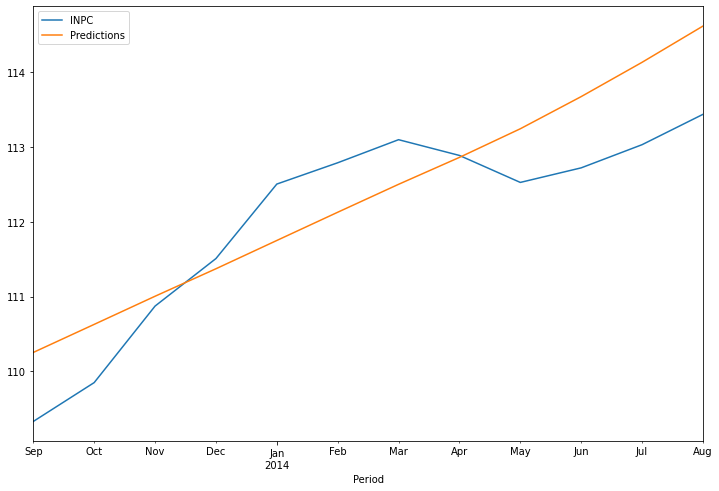

In [49]:
test.plot(figsize=(12,8))

Guardar el modelo

In [50]:
model.save('my_rnn_model.h5')

Cargar el modelo

In [51]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

In [52]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [53]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(24):   ## para cambiar el número de puntos a futuro que se desea predecir , cambiar el número que esta entre parentesis() 
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [54]:
test_predictions

[array([1.0239034], dtype=float32),
 array([1.0315247], dtype=float32),
 array([1.0391686], dtype=float32),
 array([1.0466346], dtype=float32),
 array([1.0543182], dtype=float32),
 array([1.0619847], dtype=float32),
 array([1.0695754], dtype=float32),
 array([1.0768913], dtype=float32),
 array([1.0846661], dtype=float32),
 array([1.0934055], dtype=float32),
 array([1.1027197], dtype=float32),
 array([1.1125618], dtype=float32),
 array([1.1225888], dtype=float32),
 array([1.1318247], dtype=float32),
 array([1.1412722], dtype=float32),
 array([1.1509345], dtype=float32),
 array([1.1608323], dtype=float32),
 array([1.1709709], dtype=float32),
 array([1.1813745], dtype=float32),
 array([1.1920664], dtype=float32),
 array([1.2030785], dtype=float32),
 array([1.214407], dtype=float32),
 array([1.2260191], dtype=float32),
 array([1.2379091], dtype=float32)]

In [55]:
scaled_test

array([[1.00515572],
       [1.01571073],
       [1.03649598],
       [1.04940557],
       [1.06964277],
       [1.07542773],
       [1.08169984],
       [1.07741695],
       [1.07008933],
       [1.07404746],
       [1.08033987],
       [1.0885809 ]])

In [56]:
true_predictions = scaler.inverse_transform(test_predictions)

In [57]:
true_predictions

array([[110.25161625],
       [110.62708435],
       [111.00366831],
       [111.37148399],
       [111.75002363],
       [112.12771758],
       [112.50168221],
       [112.86210387],
       [113.2451363 ],
       [113.67568661],
       [114.13455618],
       [114.61943695],
       [115.11342076],
       [115.56843769],
       [116.03387319],
       [116.50989172],
       [116.99751515],
       [117.49700189],
       [118.00954416],
       [118.53628717],
       [119.07880487],
       [119.63690932],
       [120.20899135],
       [120.79475729]])

In [58]:
test = test.reset_index()

In [59]:
test2 = pd.concat([test,pd.DataFrame(true_predictions)],axis =1)

In [60]:
test2

,Period,INPC,Predictions,0
0,2013-09-30,109.328,110.251616,110.251616
1,2013-10-31,109.848,110.627084,110.627084
2,2013-11-30,110.872,111.003668,111.003668
3,2013-12-31,111.508,111.371484,111.371484
4,2014-01-31,112.505,111.750024,111.750024
5,2014-02-28,112.790,112.127718,112.127718
6,2014-03-31,113.099,112.501682,112.501682
7,2014-04-30,112.888,112.862104,112.862104
8,2014-05-31,112.527,113.245136,113.245136
9,2014-06-30,112.722,113.675687,113.675687


In [61]:
df_total = pd.concat([df,test2],axis =0)

In [62]:
x = np.arange(0,len(df_total),1).reshape(-1,1)
len(x)

200

In [63]:
len(df_total.iloc[:,-1].values)

200

In [64]:
df_total.columns

Index(['INPC', 'Period', 'Predictions', 0], dtype='object')

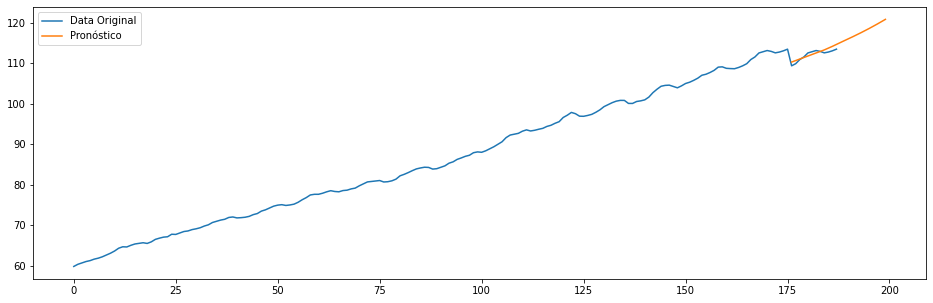

In [65]:
# comparando y_pred, vs y_test
plt.figure(figsize =(16,5))

plt.plot(x,df_total.iloc[:,0].values,label ='Data Original')
plt.plot(x,df_total.iloc[:,-1].values, label ='Pronóstico')
plt.legend(loc = 'best')